In [1]:
import pymongo
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

# MongoDB connection details
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['mydb']  # replace with your database name
collection = db['sensor']  # replace with your collection name

In [2]:
# Fetch data from MongoDB
documents = collection.find({}, {
    "deviceId": 1,
    "code": 1,
    "value": 1,
    "creationDate": 1,
    "_id": 0
})

In [3]:
documents

In [17]:
documents.cursor_id

In [18]:
# Convert to DataFrame
df = pd.DataFrame(documents)

In [19]:
df

,deviceId,code,value,creationDate
0,SAG_DPv3_QA3,T,-46.85,2024-08-22 08:16:14.451
1,SAG_DPv3_QA3,H,-6.00,2024-08-22 08:16:14.452
2,SAG_DPv3_QA3,MEA4,017/146,2024-08-22 08:16:14.452
3,SAG_DPv3_QA3,IRO,0068/4095/-46.85,2024-08-22 08:16:14.453
4,SAG_DPv3_QA3,LIA1,000000,2024-08-22 08:16:14.454
...,...,...,...,...
35709,SAG_DPv3_QA3,PS,0,2024-08-23 14:19:54.979
35710,SAB80MO0046,CS,1,2024-08-23 14:19:56.916
35711,SAB80MO0046,CT,10,2024-08-23 14:19:56.917
35712,SAB80MO0046,SS,26,2024-08-23 14:19:56.917


In [20]:
# Convert 'value' to a float
#df['value'] = df['value'].astype(float)

# Extract the '$date' field from the 'creationDate' column
df['creationDate'] = df['creationDate'].apply(lambda x: x['$date'] if isinstance(x, dict) else x)

# Convert 'creationDate' to a datetime object
df['creationDate'] = pd.to_datetime(df['creationDate'])

# Display the DataFrame
print(df)

           deviceId  code             value            creationDate
0      SAG_DPv3_QA3     T            -46.85 2024-08-22 08:16:14.451
1      SAG_DPv3_QA3     H             -6.00 2024-08-22 08:16:14.452
2      SAG_DPv3_QA3  MEA4           017/146 2024-08-22 08:16:14.452
3      SAG_DPv3_QA3   IRO  0068/4095/-46.85 2024-08-22 08:16:14.453
4      SAG_DPv3_QA3  LIA1            000000 2024-08-22 08:16:14.454
...             ...   ...               ...                     ...
35709  SAG_DPv3_QA3    PS                 0 2024-08-23 14:19:54.979
35710   SAB80MO0046    CS                 1 2024-08-23 14:19:56.916
35711   SAB80MO0046    CT                10 2024-08-23 14:19:56.917
35712   SAB80MO0046    SS                26 2024-08-23 14:19:56.917
35713   SAB80MO0046     B               322 2024-08-23 14:19:56.917

[35714 rows x 4 columns]


In [ ]:
def mongo_to_df():
    import pymongo
    import pandas as pd
    from datetime import datetime
    
    # MongoDB connection details
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client['mydb']  # replace with your database name
    collection = db['sensor']  

    documents = collection.find({}, {
        "deviceId": 1,
        "code": 1,
        "value": 1,
        "creationDate": 1,
        "_id": 0})
    
    df = pd.DataFrame(documents) 

    # Extract the '$date' field from the 'creationDate' column
    df['creationDate'] = df['creationDate'].apply(lambda x: x['$date'] if isinstance(x, dict) else x)

# Convert 'creationDate' to a datetime object
    df['creationDate'] = pd.to_datetime(df['creationDate'])

    return df

In [21]:
def plot_sensor_data(df, device_id, code, plot_type, 
                     start_date=None, end_date=None, 
                     boundary_date=None, before=True, 
                     num_values=None, first=True, 
                     value_threshold=None, min_value=True):
    
    import pandas as pd
    from matplotlib import pyplot as plt
    
    # Filter DataFrame by device_id and code
    df_filtered = df[(df['deviceId'] == device_id) & (df['code'] == code)]
    
    # Convert 'value' to float
    df_filtered['value'] = df_filtered['value'].astype(float)
    
    # Convert 'creationDate' to datetime if it's not already
    if df_filtered['creationDate'].dtype != 'datetime64[ns]':
        df_filtered['creationDate'] = pd.to_datetime(df_filtered['creationDate'])

    if plot_type == 'date_range':
        # 1) Plot for a given range of creation dates
        if start_date and end_date:
            df_filtered = df_filtered[(df_filtered['creationDate'] >= pd.to_datetime(start_date)) &
                                      (df_filtered['creationDate'] <= pd.to_datetime(end_date))]

    elif plot_type == 'date_boundary':
        # 2) Plot after/before a given creation date
        if boundary_date:
            if before:
                df_filtered = df_filtered[df_filtered['creationDate'] <= pd.to_datetime(boundary_date)]
            else:
                df_filtered = df_filtered[df_filtered['creationDate'] >= pd.to_datetime(boundary_date)]
    
    elif plot_type == 'recorded_values':
        # 3) Plot for a given range of last/first few recorded values
        if num_values:
            df_filtered = df_filtered.sort_values(by='creationDate', ascending=first).head(num_values)
    
    elif plot_type == 'value_threshold':
        # 4) Plot for a given threshold of value (min/max)
        if value_threshold is not None:
            if min_value:
                df_filtered = df_filtered[df_filtered['value'] >= value_threshold]
            else:
                df_filtered = df_filtered[df_filtered['value'] <= value_threshold]
    
    # Plotting
    plt.scatter(df_filtered['creationDate'], df_filtered['value'])
    plt.xlabel('Creation Date')
    plt.ylabel('Value')
    plt.title(f'Values vs Creation Date for Device ID: {device_id}, Code: {code}')
    plt.show()

# Example usage:
# plot_sensor_data(df, 'SAG_DPv3_QA3', 'T', 'date_range', start_date='2024-08-20', end_date='2024-08-25')
# plot_sensor_data(df, 'SAG_DPv3_QA3', 'T', 'date_boundary', boundary_date='2024-08-22', before=False)
# plot_sensor_data(df, 'SAG_DPv3_QA3', 'T', 'recorded_values', num_values=5, first=True)
# plot_sensor_data(df, 'SAG_DPv3_QA3', 'T', 'value_threshold', value_threshold=-45.0, min_value=True)


/tmp/ipykernel_9796/3774610922.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['value'] = df_filtered['value'].astype(float)


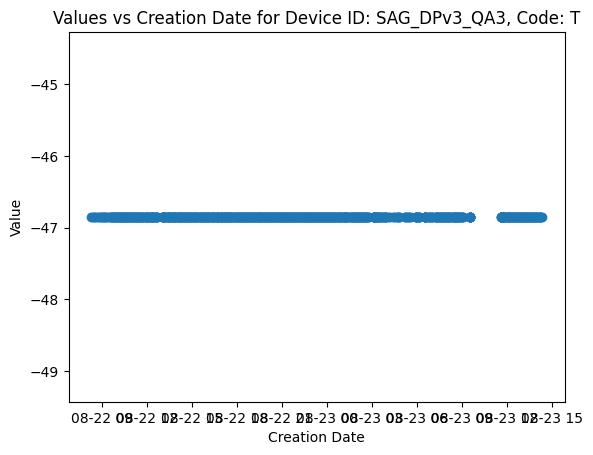

In [31]:
plot_sensor_data(df, 'SAG_DPv3_QA3', 'T', 'date_range', start_date='2024-08-20', end_date='2024-08-25')